# Quick Start -Above Ground Biomass - Species-specific

## Overview

This notebook walks us through making a request to Above Ground Biomass (AGB) Geospatial APIs for Species specific Data Layer and analyzing the results through visualizations.

Similar to the [Species Agnostic data layer](../agb_species_agnostic/agb_species_agnostic.ipynb), the Above Ground Biomass (AGB) Species Specific data layer also provides the historic and future (predictive) carbon units and CO2 capture data, but is specific to the tree species mentioned in the query. The sample here specifically queries the Para Rubber species, but the API also supports querying for Cork Oak, Bluegum Eucalyptus, Stone Pine, and Cluster Pine species in the same format as: 'para_rubber'.

Similar to future predictions for the species  agnostic data layer,even in this case the predictive models use the Coupled Model Intercomparison Project Phase 6 (CMIP6) – climate change patterns data and ISRIC Soil Grid data. 

<b>The Above Ground Biomass (AGB) Data Set currently has spatial coverage for Brazil in the temporal range from 2015 to 2100.</b>

### Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample ,mentioned in the below cell.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>

```
Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../auth/secrets.ini')```

In [ ]:
%pip install ibmpairs
%pip install rasterio
%pip install folium
%pip install configparser
%pip install matplotlib

In [2]:
import ibmpairs.client as client
import ibmpairs.query as query
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
import rasterio

import configparser
import folium
import branca.colormap as cm, numpy as np
from matplotlib import colors as colors
from IPython.display import display as display_summary
from IPython import display

Now, let's create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

In [3]:
config = configparser.RawConfigParser()
config.read('../../auth/secrets.ini')

# Getting the Auth token
EI_ORG_ID     = config.get('EI', 'api.org_id') 
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_API_KEY     = config.get('EI', 'api.api_key')

EI_client_v4 = client.get_client(org_id    = EI_ORG_ID,
                                  tenant_id = EI_TENANT_ID,
                                  api_key     = EI_API_KEY,
                                  version   = 4
                                )

2024-10-10 18:30:17 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-10-10 18:30:17 - paw - INFO - Legacy Environment is False
2024-10-10 18:30:17 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2024-10-10 18:30:19 - paw - INFO - Authentication success.
2024-10-10 18:30:19 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v4


The following code snippet submits the query for the AGB Data Layer <i>above-ground-biomass</i>  for years 2022, 2023, 2024 and 2025 using Geospatial APIs V4 query API, waits for it to finish, downloads the data to the download folder, loads the data to memory and displays it on screen. This could take a few minutes to complete as all the data is brought together.

Let's go ahead, define and submit a query.

<b>Note:</b> Before starting, we have to install ibm pairs using `pip3 install -U ibmpairs`

In [4]:
# Define and submit the query
species_specific_title = "AGB - Species specific"
# submit, checks the status and downloads the result of the query (this will poll until the result is ready)
species_specific_query_object = query.submit_check_status_and_download({
                  "name": "Species Specific Above Ground Biomass - " + species_specific_title,
                  "spatial": {
                    "geojson": {
                      "type": "Feature",
                      "geometry": {
                        "type": "MultiPolygon",
                        "coordinates": [
                          [
                            [
                              [
                                -55.104713352431425,
                                -4.118418722212553
                              ],
                              [
                                -55.23040288011767,
                                -4.116496437561936
                              ],
                              [
                                -55.227771727407934,
                                -4.013831032184584
                              ],
                              [
                                -55.10126584763694,
                                -4.0164692915327285
                              ],
                              [
                                -55.104713352431425,
                                -4.118418722212553
                              ]
                            ]
                          ]
                        ]
                      }
                    }
                  },
                  "temporal": {
                    "years": [
                        2020,
                        2021,
                        2022,
                        2023,
                        2024
                    ]
                  },
                  "layers": [
                    {
                      "datalayer": "tree-species-above-ground-biomass-natural",
                      "properties": {
                        "species": "para_rubber"
                      }
                    }
                  ]
                },EI_client_v4)

2024-10-10 18:30:19 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-10-10 18:30:20 - paw - INFO - The query was successfully submitted with the id: 1728561600_03620657.
2024-10-10 18:30:22 - paw - INFO - The query 1728561600_03620657 has the status Queued.
2024-10-10 18:30:53 - paw - INFO - The query 1728561600_03620657 has the status Running.
2024-10-10 18:31:24 - paw - INFO - The query 1728561600_03620657 has the status Succeeded.
2024-10-10 18:31:24 - paw - INFO - The query 1728561600_03620657 was successful after checking the status.
2024-10-10 18:31:55 - paw - INFO - The query 1728561600_03620657 has the status Succeeded.
2024-10-10 18:31:55 - paw - INFO - The query 1728561600_03620657 was successful after checking the status.
2024-10-10 18:31:55 - paw - INFO - The query download folder is set to the path /Users/environmental-intelligence/Environmental-Intelligence-internal/geospatial_analytics/v4_apis/samples/quickstart/agb_species_specific/download/.
2024-10

Let's look at the summary from the result of the query:

In [5]:
species_specific_para_rubber_title='Above Ground Biomass-species specific :'+str(species_specific_query_object.temporal.years)
species_specific_file_list = species_specific_query_object.list_files()
#This gets the folder location of where the query result is downloaded.
download_location = species_specific_query_object.get_download_folder() + species_specific_query_object.id
summary_file = download_location + '/' +'Above Ground Biomass-species specific summary agb.json'

summary = pd.read_json(summary_file)
print(species_specific_para_rubber_title)
display_summary(summary)

Above Ground Biomass-species specific :[2020, 2021, 2022, 2023, 2024]


year                                 layer_name    area_in_ha  \
0  2020  tree-species-above-ground-biomass-natural  15849.245721   
1  2021  tree-species-above-ground-biomass-natural  15849.245721   
2  2022  tree-species-above-ground-biomass-natural  15849.245721   
3  2023  tree-species-above-ground-biomass-natural  15849.245721   
4  2024  tree-species-above-ground-biomass-natural  15849.245721   

   baseline_agb_min_units  baseline_agb_max_units  baseline_agb_mean_units  \
0                0.630999               76.358371                34.825807   
1                1.040409               76.358371                34.084735   
2                0.331162               76.358371                31.957176   
3                0.630999               71.417088                34.239916   
4                     NaN                     NaN                      NaN   

   baseline_total_agb_units  baseline_total_carbon_tons  \
0              6.820774e+06                3.410387e+06   
1              6.675632e+06                3.337816e+06   
2              6.258941e+06                3.129470e+06   
3              6.706025e+06                3.353012e+06   
4                       NaN                         NaN   

   baseline_total_co2_tons agb_analytics_type  predicted_total_agb_units  \
0             1.251612e+07         historical                        NaN   
1             1.224978e+07         historical                        NaN   
2             1.148516e+07         historical                        NaN   
3             1.230555e+07         historical                        NaN   
4                      NaN         prediction               7.111024e+06   

   predicted_total_carbon_tons  predicted_total_co2_tons  
0                          NaN                       NaN  
1                          NaN                       NaN  
2                          NaN                       NaN  
3                          NaN                       NaN  
4                 3.555512e+06              1.304873e+07

Let's define some utility functions to display the downloaded raster tiff files.

In [6]:
def get_extent(f):
    with open(f, 'r') as ff:
        stats = json.load(ff)
    boundingBox=stats["boundingBox"]
    myextent = [boundingBox["minLongitude"],boundingBox["maxLongitude"],boundingBox["minLatitude"],boundingBox["maxLatitude" ] ]
    return myextent


def display_raster(raster_file_name, colorMap, title = None, Max=None, Min=None, myextent=None):
    if raster_file_name.endswith('.tiff'):
        with rasterio.open(raster_file_name) as raster_file:
            if not myextent:
                myextent=get_extent(raster_file_name+".json")
            data = raster_file.read(1)
            plt.figure(figsize = (20, 12))
            if Max is None:
                Max=data.max()
            if Min is None:
                Min = data.min()
            plt.imshow(data, cmap = colorMap, vmin = Min, vmax = Max,extent = myextent)
            if not title:
                title=os.path.basename(raster_file_name)
            plt.title(title)
            plt.colorbar()
            plt.show()

Let's display the resulting raster tiff file(s) using the above methods.

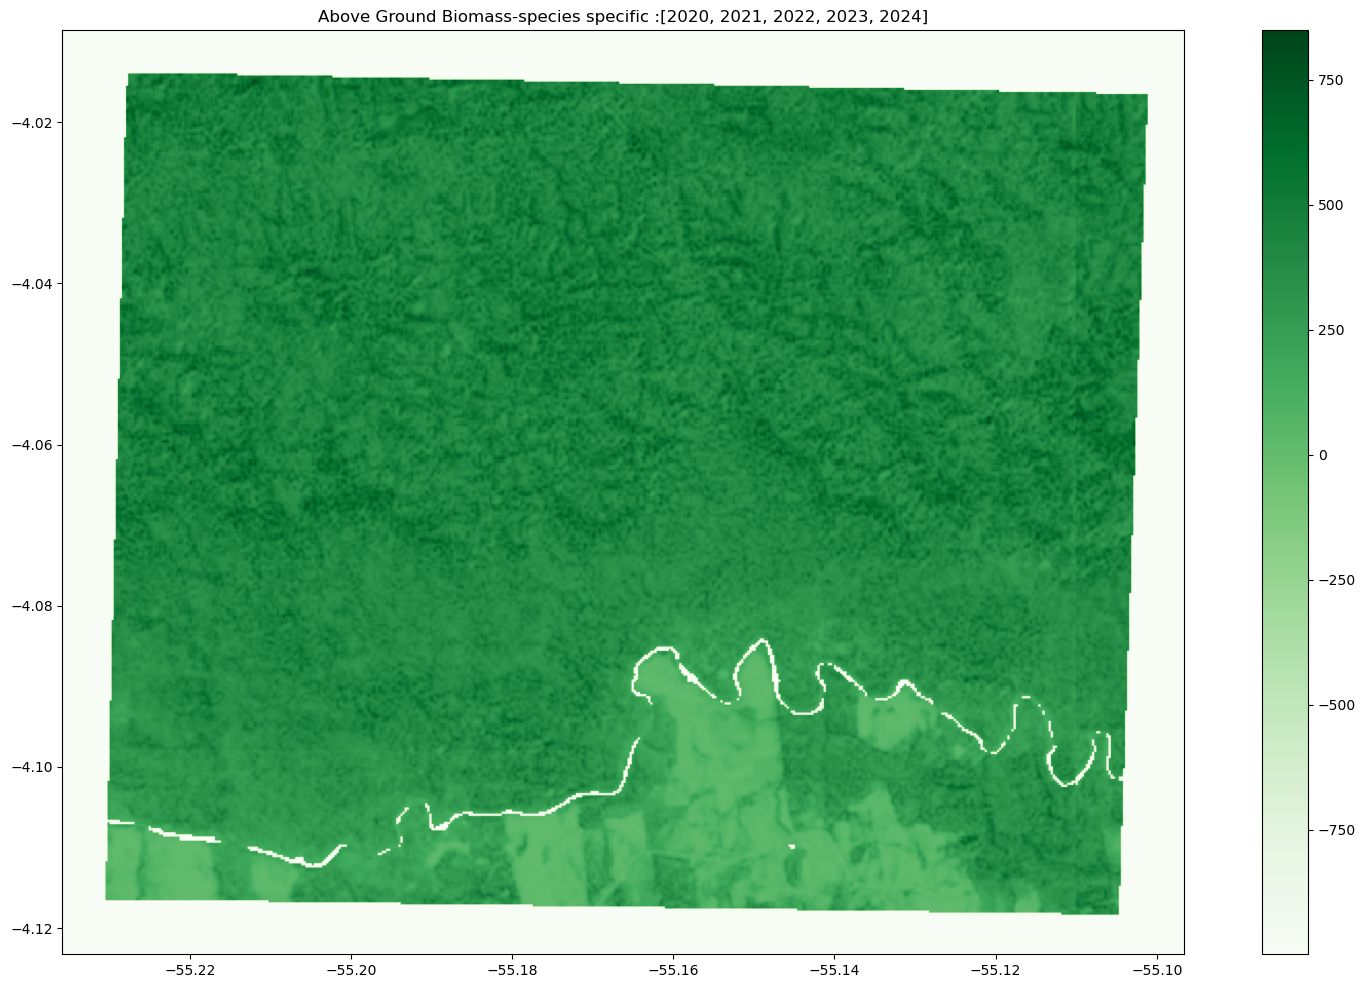

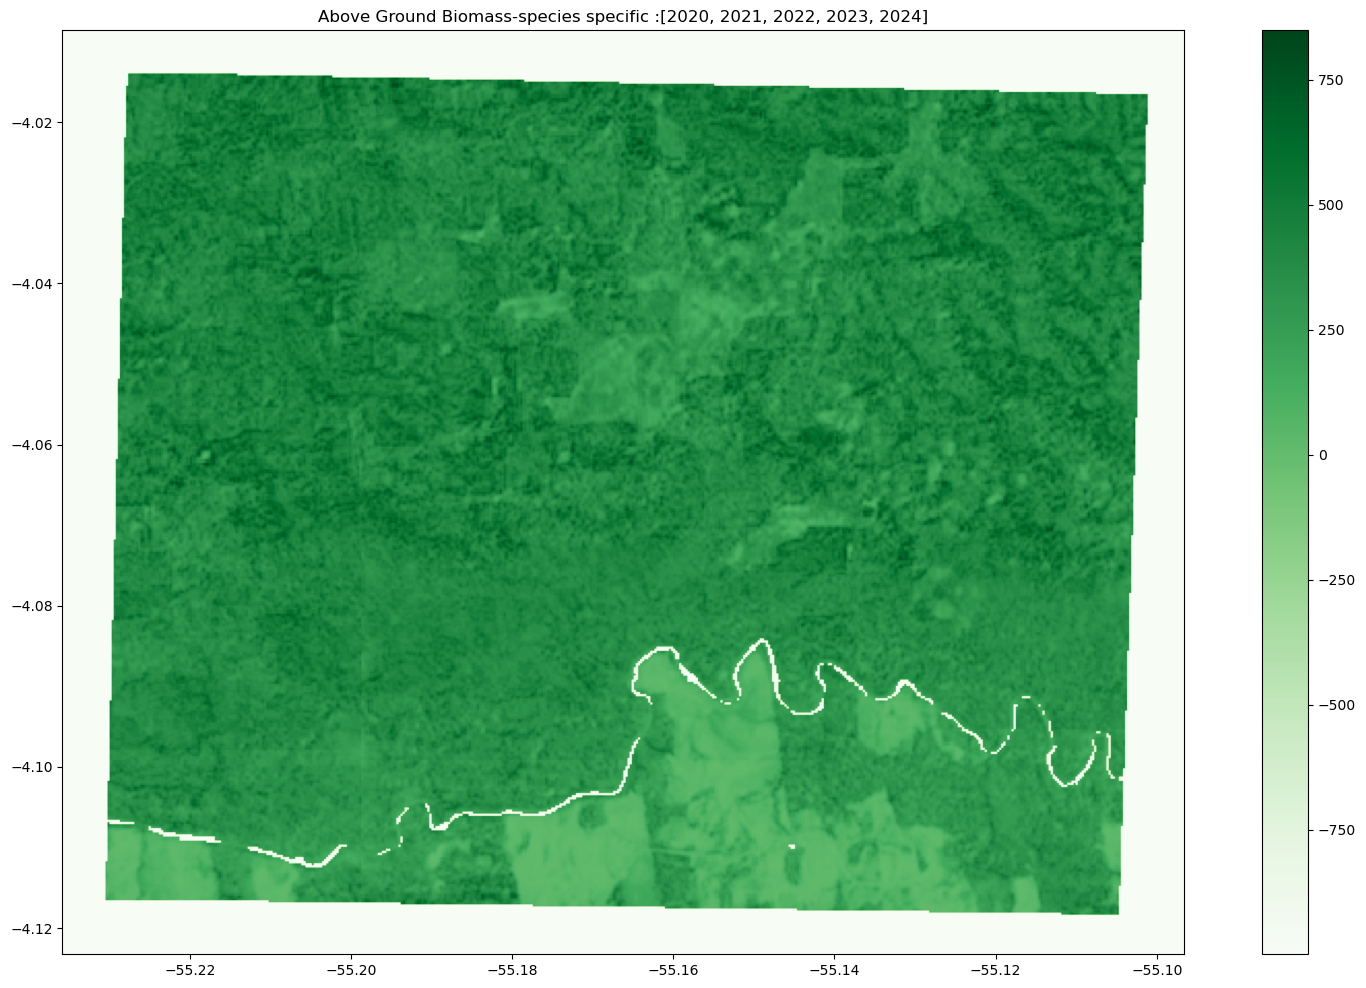

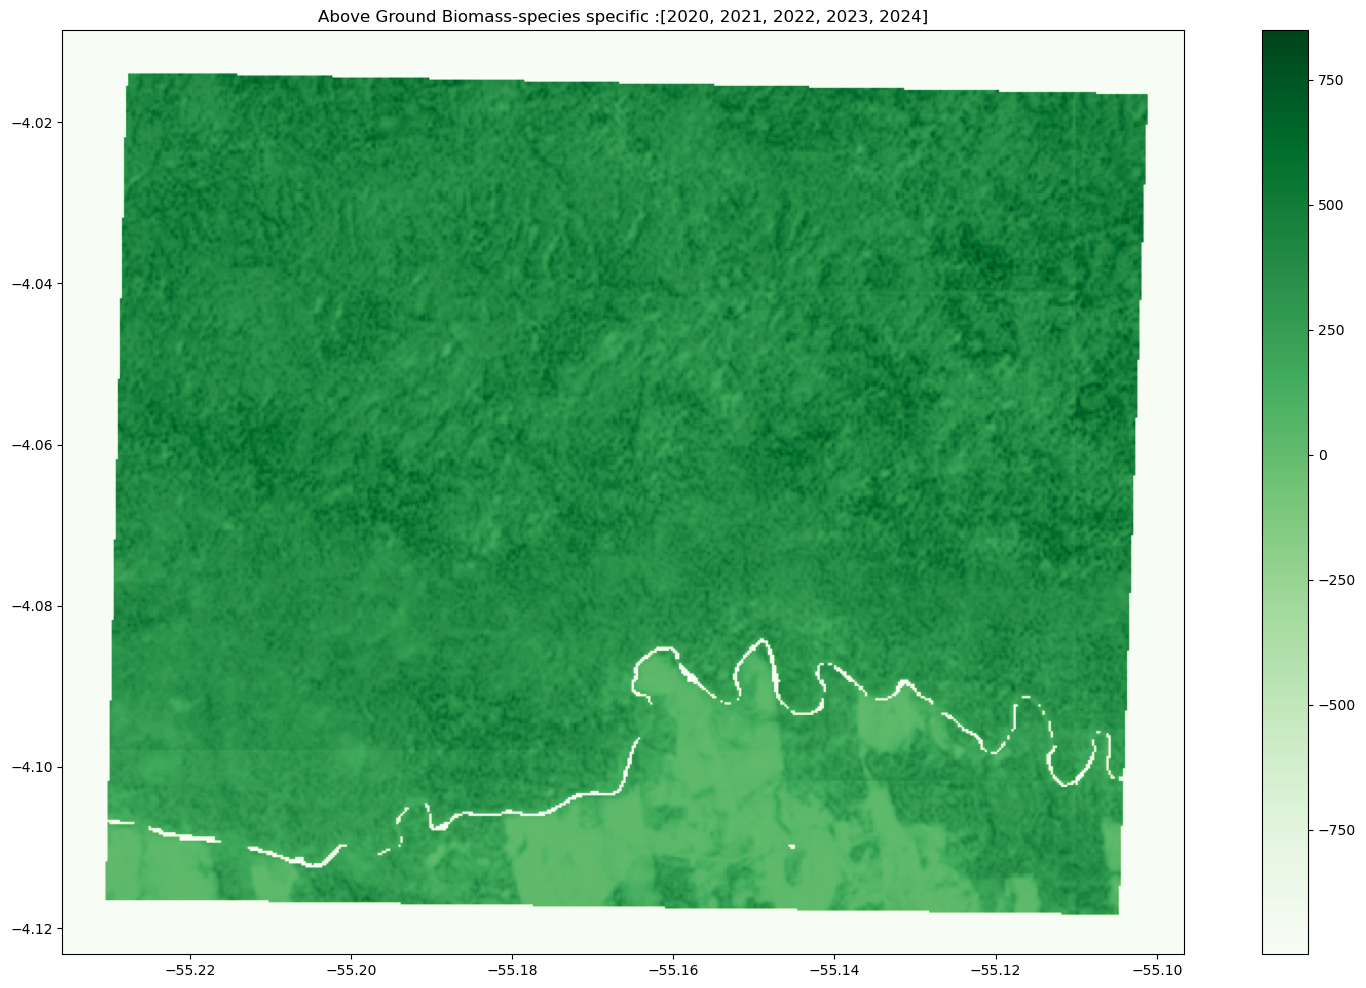

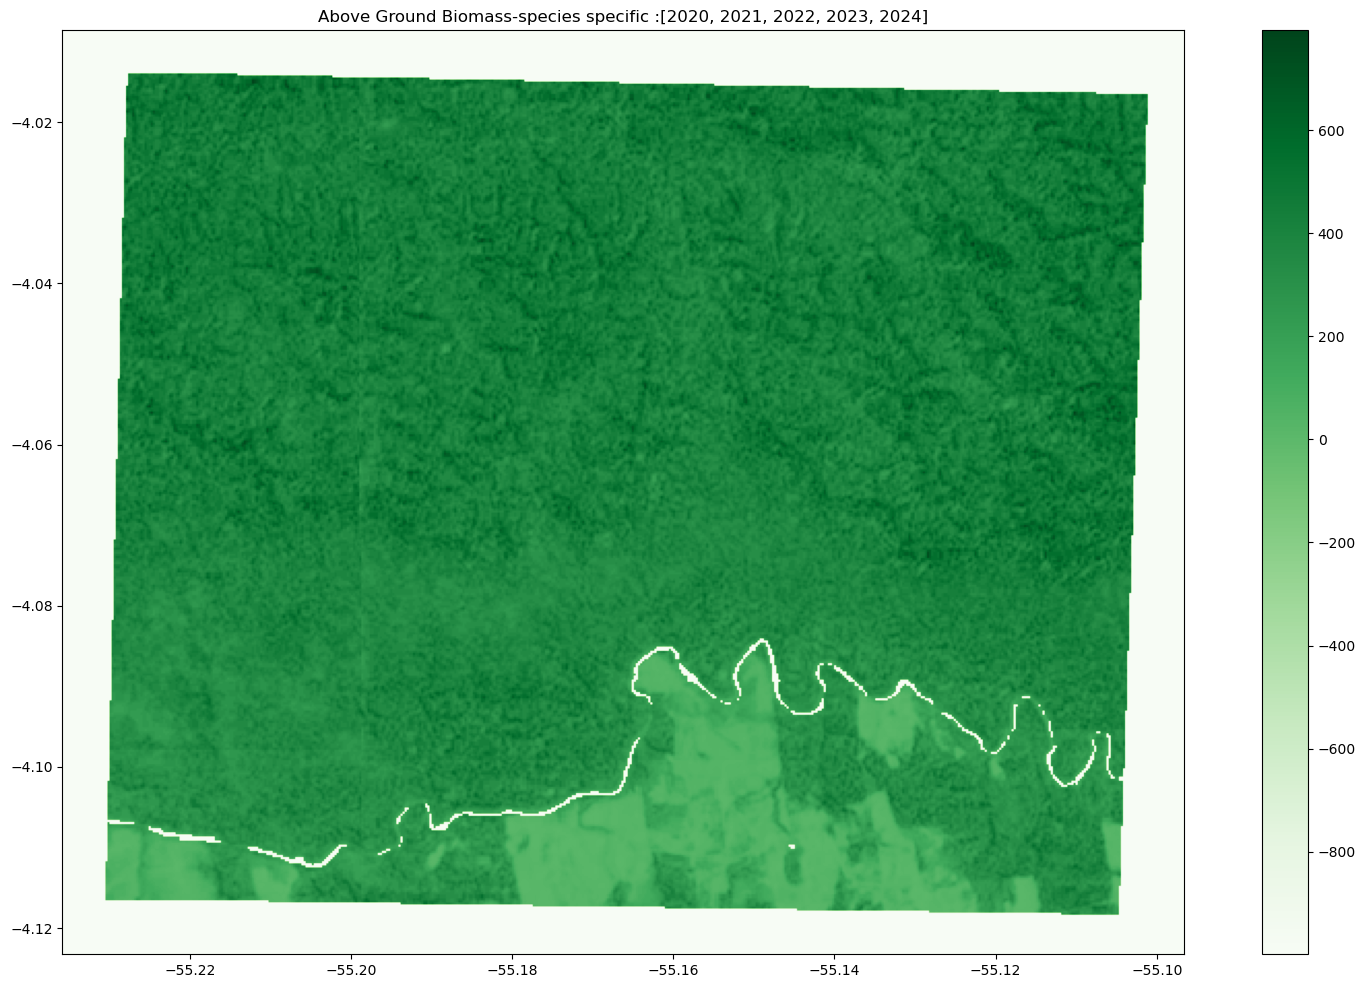

In [7]:
# Now display the resulting Tiff files.
species_specific_file_list.sort()
for f in species_specific_file_list:
    if f.endswith('.tiff'):
        display_raster(f, 'Greens', title=species_specific_para_rubber_title)   # , Max=300)

#### Understanding the Sample

<b>Code:</b>

Let's go over the details of the above example, 

The above code snippet is run using Geospatial APIs V4 query API to retrieve carbon units and CO2 capture for:

* A specific area which is a Multipolygon defined as a standard Geojson format for the spatial data.
* The temporal intevals' timestamp as years. In this example, we are passing the years from 2022 to 2025 as the temporal range. Years from 2022 and 2023 are historical baseline years while 2024 and 2025 are prediction years. Note that any years beyond the current year are prediction years.
* For a specific species type <i>para_rubber</i>.

Submitting the query above does not immediately return data because the raster area query takes time and its operation is asynchronous. In this case we use `query.submit()`. This submits the query to Geospatial APIs V4 query API. One the query is submitted, we use `download()` method that checks the status of the query as it runs and, once complete, downloads the results of the query as a zip file.

You can see from the output of the call that that `species_specific_query_object.download()` prints the status of the job as it progresses.

On the first line of the log, you can see the query Id that has been assigned by Geospatial APIs to the query job will look something like "1718236800_23597132" and is unique for each query submitted. After this, you can see the query transistion through Queued, Initializing, Running and finally succeeded. You won't necessarily see all of these stages printed out depending on how busy the Geospatial APIs system is at the time you submit.

Once the processing is complete you can see that the resulting query zip file is placed in the download folder. This folder is usually placed inside the directory where you run this notebook from.

The library will automatically unzip this zip file for you and into a directory named after the query Id. In this case the contents are as follows:

- Above Ground Biomass-species specific summary agb.json
- Above Ground Biomass-species specific agb-01_01_2022T00_00_00.tiff
- Above Ground Biomass-species specific agb-01_01_2022T00_00_00.tiff.json
- Above Ground Biomass-species specific agb-01_01_2023T00_00_00.tiff
- Above Ground Biomass-species specific agb-01_01_2023T00_00_00.tiff.json
- data_acknowledgement.txt
- output.info

The `Above Ground Biomass-species specific summary agb.json` file gives you a brief about the information from each year specified in the query.

As you can see the summary json file gives the agb units, carbon units and CO2 capture of historical and predicted years. It also provides the area in hectares, baseline agb min, max, mean and total units for the Data Layer <i>tree-species-above-ground-biomass-natural</i>.

``` json
[
    {
        "year": 2022,
        "layer_name": "tree-species-above-ground-biomass-natural",
        "area_in_ha": 2916450.629599,
        "baseline_agb_min_units": 0.028237,
        "baseline_agb_max_units": 81.483353,
        "baseline_agb_mean_units": 28.7352,
        "baseline_total_agb_units": 1016874347.76407,
        "baseline_total_carbon_tons": 508437173.882035,
        "baseline_total_co2_tons": 1865964428.147068,
        "agb_analytics_type": "historical"
    },
    {
        "year": 2023,
        "layer_name": "tree-species-above-ground-biomass-natural",
        "area_in_ha": 2916450.629599,
        "baseline_agb_min_units": 0.028237,
        "baseline_agb_max_units": 81.483353,
        "baseline_agb_mean_units": 30.871398,
        "baseline_total_agb_units": 1092767358.221962,
        "baseline_total_carbon_tons": 546383679.110981,
        "baseline_total_co2_tons": 2005228102.3373,
        "agb_analytics_type": "historical"
    },
    {
        "year": 2024,
        "layer_name": "tree-species-above-ground-biomass-natural",
        "area_in_ha": 2916450.629599,
        "predicted_total_agb_units": 1165474710.682635,
        "predicted_total_carbon_tons": 582737355.341318,
        "predicted_total_co2_tons": 2138646094.102635,
        "agb_analytics_type": "prediction"
    },
    {
        "year": 2025,
        "layer_name": "tree-species-above-ground-biomass-natural",
        "area_in_ha": 2916450.629599,
        "predicted_total_agb_units": 1239499262.292857,
        "predicted_total_carbon_tons": 619749631.146428,
        "predicted_total_co2_tons": 2274481146.307392,
        "agb_analytics_type": "prediction"
    }
]

```

The .tiff.json files hold metadata about the raster tiff images like the information about pixel and raster image statistics, For example:
``` json
{
    "pixelType": "fl",
    "pixelNoDataVal": -9999,
    "spatialRef": "EPSG:4326",
    "boundingBox": {
        "minLatitude": -4.942464,
        "maxLatitude": -3.549824,
        "minLongitude": -56.497408,
        "maxLongitude": -54.654208
    },
    "pixelDimensions": {
        "pixelSizeDegreeLatitude": 0.000256,
        "pixelSizeDegreeLongitude": 0.000256,
        "numberPixelsLatitude": 5440,
        "numberPixelsLongitude": 7200
    },
    "rasterStatistics": {
        "pixelMin": 0.31374,
        "pixelMax": 905.3705833454812,
        "pixelCount": 39168000,
        "pixelMean": 319.279996,
        "pixelStandardDeviation": 174.4709
    },
    "agbAnalytics": {
        "area_in_ha": 2916450.629599,
        "baseline_agb_min_units": 0.028237,
        "baseline_agb_max_units": 81.483353,
        "baseline_agb_mean_units": 28.7352,
        "baseline_total_agb_units": 1016874347.76407,
        "baseline_total_carbon_tons": 508437173.882035,
        "baseline_total_co2_tons": 1865964428.147068
    }
}

```

The `data_acknowledgement.txt` file contains acknowledgements associated with the data we provide. 

The `output.info` file maps the images files back to the Geospatial APIs data layers that were used to produce them:

``` json
{"files":[{"name":"Above Ground Biomass-canopy height-01_01_2022T00_00_00","datalayerId":"38001","datalayerName":"canopy height","timestamp":1640995200000,"layerType":"raster"},{"name":"Above Ground Biomass-canopy height-01_01_2023T00_00_00","datalayerId":"38001","datalayerName":"canopy height","timestamp":1672531200000,"layerType":"raster"}]}
```


<b>Output:</b>

The output is displayed in two forms: 
- The first one is a table that presents the data of each year into different rows. If we observe the table, the data is presented in such a way that the historical information is put first and the predicted information is put later to give the user an understanding of how the agb cover has increased over the years and how it is predicted based on the available historical infomartion.
- The second one is the raster tiff file plotted on the coordinate system. 

There are many other ways you can visualize and understand the data that's been retrieved, for example:

We can draw a combined line chart with the available data from both baseline and predicted information 

Combined agb units, total carbon tons and CO2 tons for AGB - Species specific


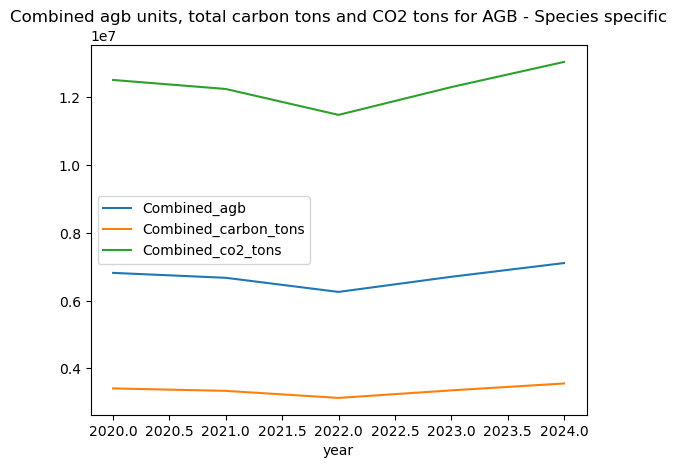

Combined_agb  Combined_carbon_tons  Combined_co2_tons
year                                                       
2020  6.820774e+06          3.410387e+06       1.251612e+07
2021  6.675632e+06          3.337816e+06       1.224978e+07
2022  6.258941e+06          3.129470e+06       1.148516e+07
2023  6.706025e+06          3.353012e+06       1.230555e+07
2024  7.111024e+06          3.555512e+06       1.304873e+07

In [8]:
agb_predictions_title='Combined agb units, total carbon tons and CO2 tons for '+ species_specific_title
combined_df = pd.DataFrame(summary[['year', 'baseline_total_agb_units','baseline_total_carbon_tons','baseline_total_co2_tons','predicted_total_agb_units','predicted_total_carbon_tons','predicted_total_co2_tons']]).set_index('year')
plot_pcombined_df=pd.DataFrame()
plot_pcombined_df['Combined_agb'] = combined_df['baseline_total_agb_units'].fillna(0) + combined_df['predicted_total_agb_units'].fillna(0)
plot_pcombined_df['Combined_carbon_tons'] = combined_df['baseline_total_carbon_tons'].fillna(0) + combined_df['predicted_total_carbon_tons'].fillna(0)
plot_pcombined_df['Combined_co2_tons'] = combined_df['baseline_total_co2_tons'].fillna(0) + combined_df['predicted_total_co2_tons'].fillna(0)
g = plot_pcombined_df.plot.line(title=agb_predictions_title)
print(agb_predictions_title)
plt.show()
plot_pcombined_df

Below is the code snippet to overlay the tiff on a world map to get an interactive visual display, after which we display the screenshot of the same for ease of rendering the notebook.

In [ ]:
#For visualizing maps
def create_fast_colormap_for_range(mycmmap_choice,vmin,vmax, empty_val):
    cm = mycmmap_choice.scale(vmin,vmax)   # cm.linear.Spectral_07.scale(0, 20)  # .to_step(1)   
    cmArray = []
    for i in range(vmin, vmax, 1):
        if i> vmax or i< vmin or  i == empty_val:   # i>20 or i==0:
            cmArray.insert(i,(1, 0, 0, 0)) 
        else:
            cmArray.insert(i,colors.to_rgba(cm(i), 0.8)) 
    return cmArray
cmArray = create_fast_colormap_for_range(cm.linear.Greens_09, 10, 282, 0) #cm.linear.Spectral_07.scale(0,20)
species_specific_file_list = species_specific_query_object.list_files()
for file in species_specific_file_list:
    if file.endswith('.tiff'):
        with rasterio.open(file) as raster:
            # Display the boundaries of the raster image for a visual check
            rb = raster.bounds
            map = folium.Map( max_bounds=True,
                    location=[(rb.bottom+rb.top)/2, (rb.left+rb.right)/2],   # [40.8768,-73.6195],
                    zoom_start=12,
                    min_lat=rb.bottom, # min_lat,
                    max_lat=rb.top,    # max_lat,
                    min_lon=rb.left,   # min_lon,
                    max_lon=rb.right   #max_lon 
                    )
            data = raster.read(1)
            data[data==-9999] = np.nan_to_num(np.nan)
            data[data==0] = np.nan_to_num(np.nan)
            folium.raster_layers.ImageOverlay(
                        image=data.astype(np.uint8),opacity=0.7, 
                        colormap=lambda value: cmArray[value],
                        bounds=[[rb.bottom, rb.left], [rb.top, rb.right]]
                    ).add_to(map)
            map.add_child(cm.linear.Greens_09.scale(10, 282))
map

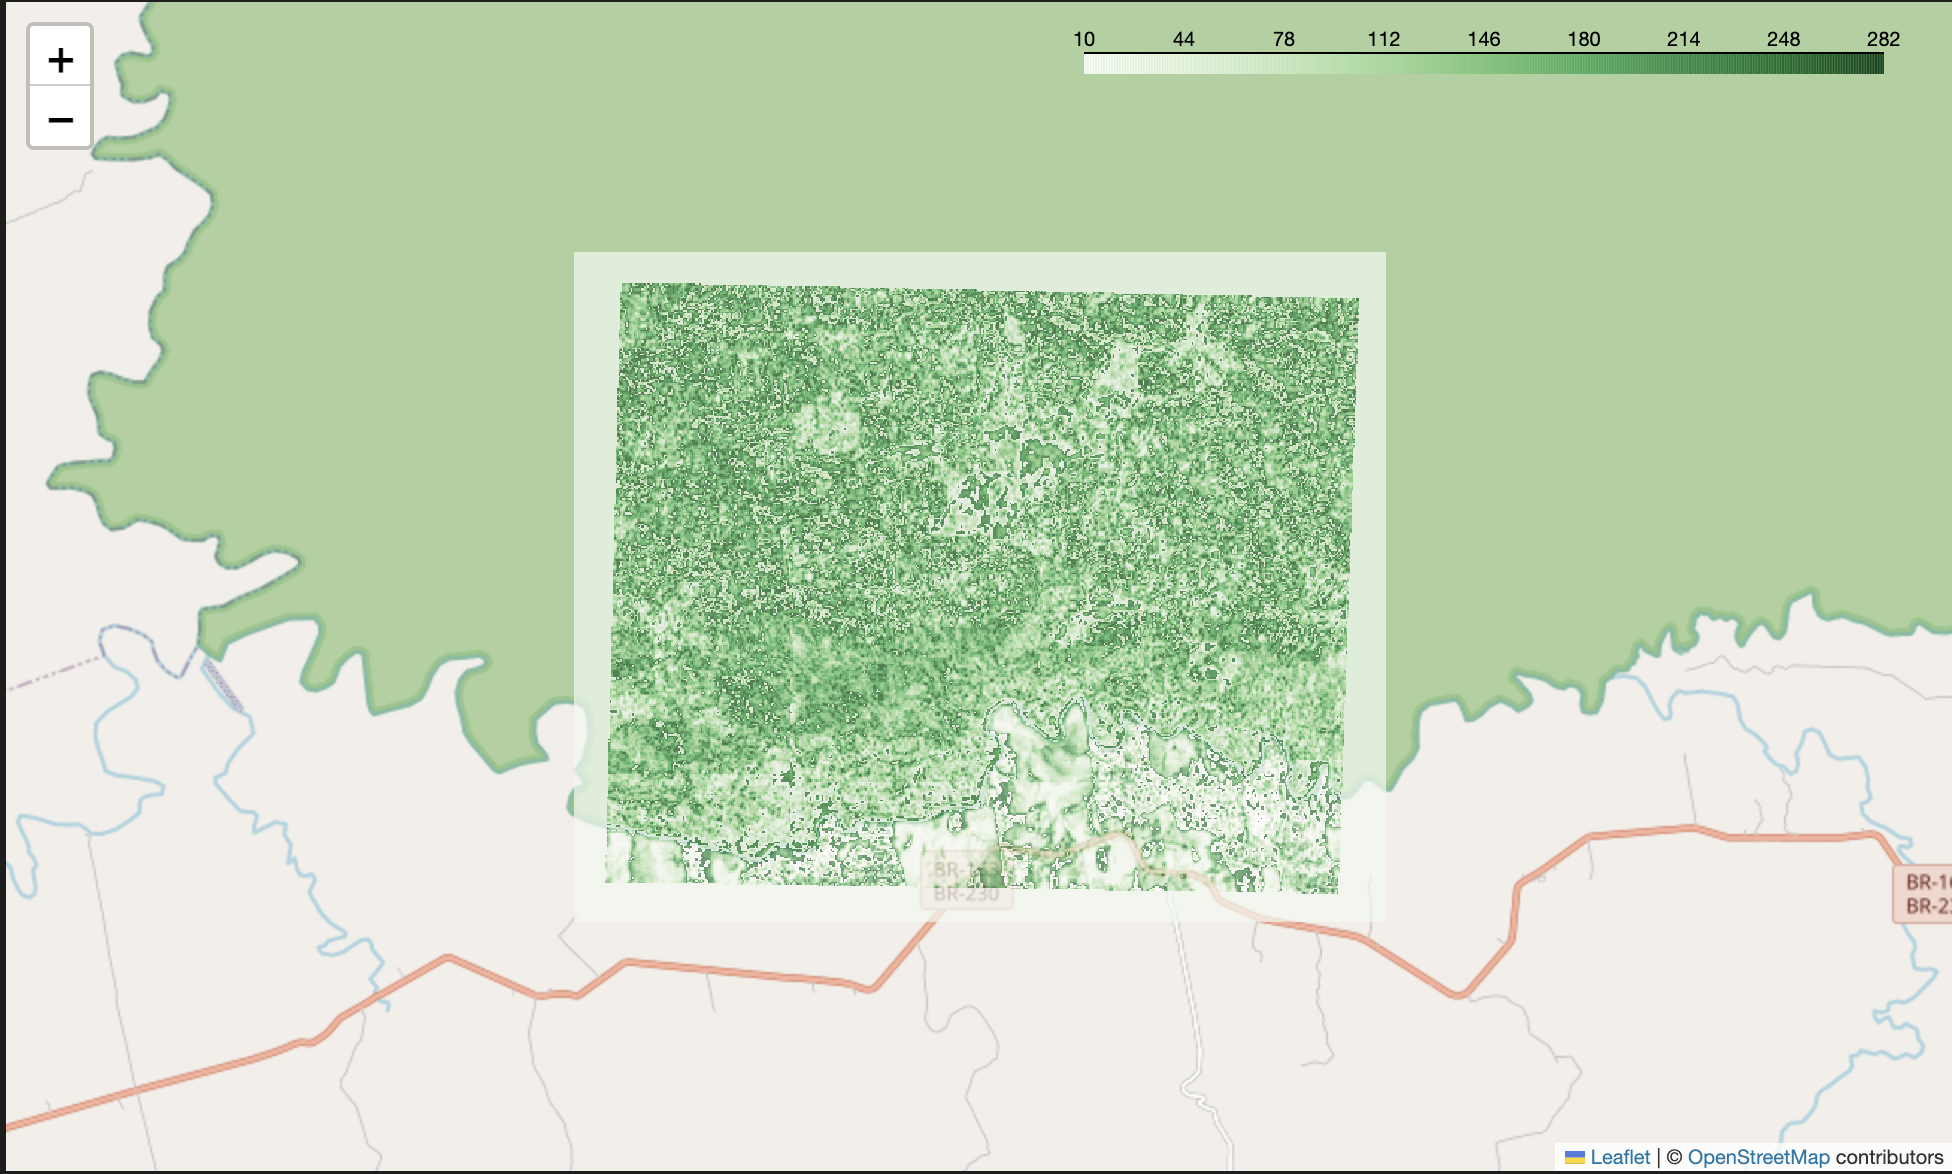

In [10]:
display.Image('agb_species_specific.png')